## Flux components 

There is probably a lot more going on with the sub-grid fluxes than just dissipation, so we can try to understand the impact the different components the flux and their flux divergences have. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

We want to work with the raw data and only generate the filtered fields. 
This is mostly to just have the right grids (the ML data we generated was only a C-grid). 

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

['leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge300day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge60day']

In [4]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/prog.zarr')

In [5]:
ds = ds.chunk({'Time':1,'xh':-1,'yh':-1,'xq':-1,'yq':-1}).isel(Time=slice(0,100))

In [6]:
def filter_dataset(ds, Lfilter): 
    
    dx = ds.xh.diff('xh')[0].values*1e3
    wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    
    filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     grid_vars = {'wet_mask': wet_mask})
    
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])
    
    ds_filt = xr.Dataset() # For storing the filtered data 
    print('Started')
    ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
    ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')
    u_c = xgrid.interp(ds.u.fillna(0), 'X')
    v_c = xgrid.interp(ds.v.fillna(0), 'Y')
    ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
    ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')
    
    print('Filtered fields computed')
    
    ds_filt['uh'] = ds.h*u_c
    ds_filt['vh'] = ds.h*v_c
    
    ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
    ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
    
    ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
    ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
    
    ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']
    ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']

    print('Fluxes computed')
    
    ds_filt['dudx'] = xgrid.interp(xgrid.diff(ds_filt.u, 'X')/dx, 'X')
    ds_filt['dvdx'] = xgrid.interp(xgrid.diff(ds_filt.v, 'X')/dx, 'X')
    ds_filt['dudy'] = xgrid.interp(xgrid.diff(ds_filt.u, 'Y')/dx, 'Y')
    ds_filt['dvdy'] = xgrid.interp(xgrid.diff(ds_filt.v, 'Y')/dx, 'Y')
    ds_filt['slope_x'] = xgrid.interp(xgrid.diff(ds_filt.e, 'X')/dx, 'X')
    ds_filt['slope_y'] = xgrid.interp(xgrid.diff(ds_filt.e, 'Y')/dx, 'Y')
    
    print('Gradients computed')
    
    return ds_filt

In [7]:
Lfilt = 100e3

In [8]:
ds_filt = filter_dataset(ds, Lfilt)

Started
Filtered fields computed
Fluxes computed
Gradients computed


In [9]:
xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

In [10]:
def return_right_var_names(ds_L, L): 
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    choice = 1 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    return ds_test

In [11]:
ds_ML = return_right_var_names(ds_filt, Lfilt/1e3)

### Projection onto parallel and perp directions relative to the slope direction

In [12]:
def perp_para(ds): 
    ''' Perp and para directions are defined as perp to isocontours of isopycnal height and elsewise
    '''
    
    S_mag = (ds.Sx * ds.Sx + ds.Sy * ds.Sy)**0.5

    # Unit vector components in S direction
    Shatx = ds.Sx/S_mag
    Shaty = ds.Sy/S_mag

    # Unit vector components perp to S direction
    Nhatx = - ds.Sy/S_mag
    Nhaty = ds.Sx/S_mag

    ds['Sfn_perp_scalar'] = (ds.Sfnx * Shatx + ds.Sfny * Shaty)
    ds['Sfn_para_scalar'] = (ds.Sfnx * Nhatx + ds.Sfny * Nhaty)

    ds['Sfn_perp_x'] = ds['Sfn_perp_scalar'] * Shatx
    ds['Sfn_perp_y'] = ds['Sfn_perp_scalar'] * Shaty

    ds['Sfn_para_x'] = ds['Sfn_para_scalar'] * Nhatx
    ds['Sfn_para_y'] = ds['Sfn_para_scalar'] * Nhaty
    
    
    return ds

In [13]:
ds = perp_para(ds_ML)

In [14]:
ds.load();

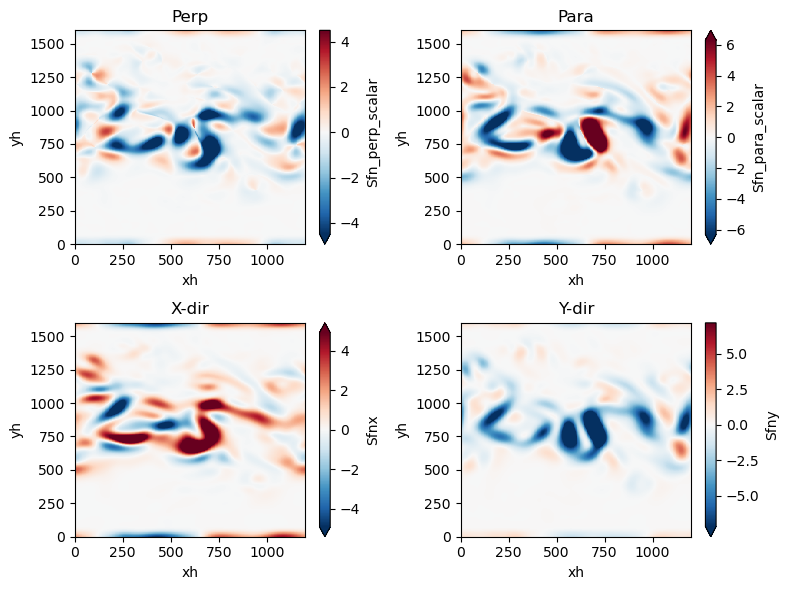

In [15]:
plt.figure(figsize=(8,6)) 

plt.subplot(221)
ds.Sfn_perp_scalar.isel(Time=-1).plot(robust=True)
plt.title('Perp')

plt.subplot(222)
ds.Sfn_para_scalar.isel(Time=-1).plot(robust=True)
plt.title('Para')

plt.subplot(223)
ds.Sfnx.isel(Time=-1).plot(robust=True)
plt.title('X-dir')

plt.subplot(224)
ds.Sfny.isel(Time=-1).plot(robust=True)
plt.title('Y-dir')

plt.tight_layout()

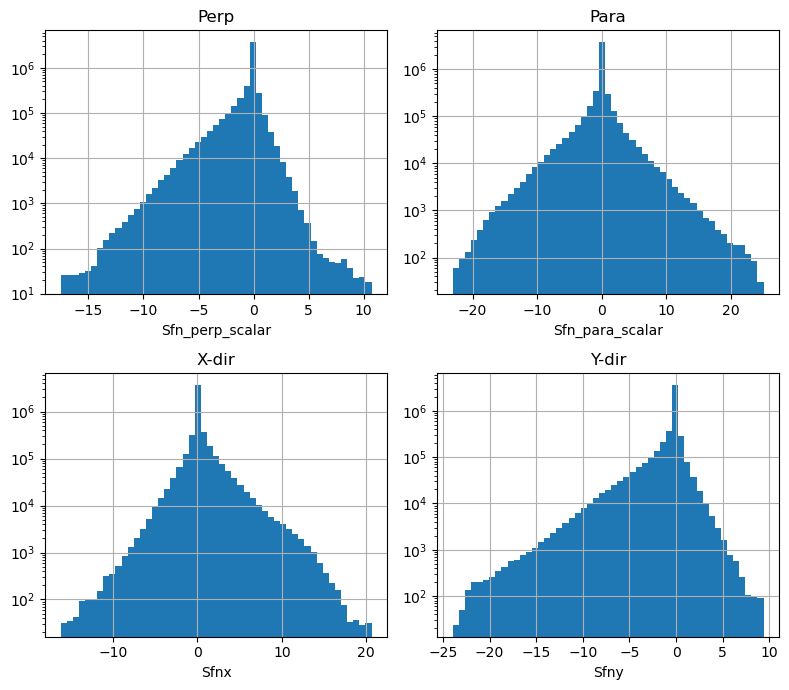

In [16]:
plt.figure(figsize=(8, 7))

plt.subplot(221)
ds.Sfn_perp_scalar.sel(yh=slice(100, 1500)).isel(Time=slice(0, 50)).plot.hist(bins=51)
plt.yscale('log')
plt.title('Perp')
#plt.xlim(-12, 12)
plt.grid()

plt.subplot(222)
ds.Sfn_para_scalar.sel(yh=slice(100, 1500)).isel(Time=slice(0, 50)).plot.hist(bins=51)
plt.yscale('log')
#plt.xlim(-12, 12)
plt.title('Para')
plt.grid()

plt.subplot(223)
ds.Sfnx.sel(yh=slice(100, 1500)).isel(Time=slice(0, 50)).plot.hist(bins=51)
plt.yscale('log')
#plt.xlim(-12, 12)
plt.title('X-dir')
plt.grid()

plt.subplot(224)
ds.Sfny.sel(yh=slice(100, 1500)).isel(Time=slice(0, 50)).plot.hist(bins=51)
plt.yscale('log')
#plt.xlim(-12, 12)
plt.title('Y-dir')
plt.grid()


plt.tight_layout()

### Dissipation 

In [17]:
def dissipative_prop(ds, Sfnx='Sfnx', Sfny='Sfny', norm=True):

    S_mag = ds.Sx*ds.Sx + ds.Sy*ds.Sy
    diss_true = ds.Sx*ds[Sfnx] + ds.Sy*ds[Sfny]
    #diss_pred = ds.Sx*ds_pred.Sfnx + ds.Sy*ds_pred.Sfny
    
    if norm==True:
        return diss_true/S_mag#, diss_pred/S_mag
    else:
        return diss_true

In [18]:
diss_perp = dissipative_prop(ds, 'Sfn_perp_x','Sfn_perp_y', norm=False)
diss_para = dissipative_prop(ds, 'Sfn_para_x','Sfn_para_y', norm=False) #should be zero

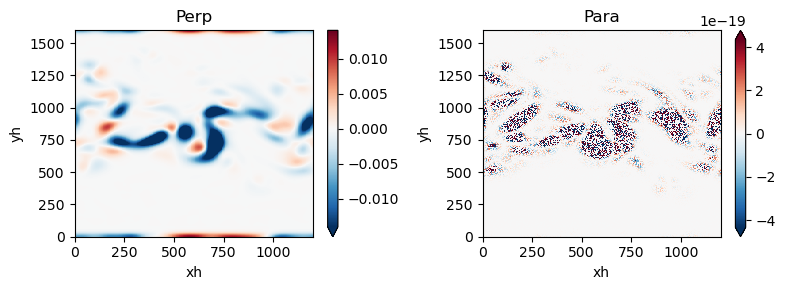

In [19]:
plt.figure(figsize=(8,3)) 

plt.subplot(121)
diss_perp.isel(Time=-1).plot(robust=True)
plt.title('Perp')

plt.subplot(122)
diss_para.isel(Time=-1).plot(robust=True)
plt.title('Para')

plt.tight_layout()

### Overturning 

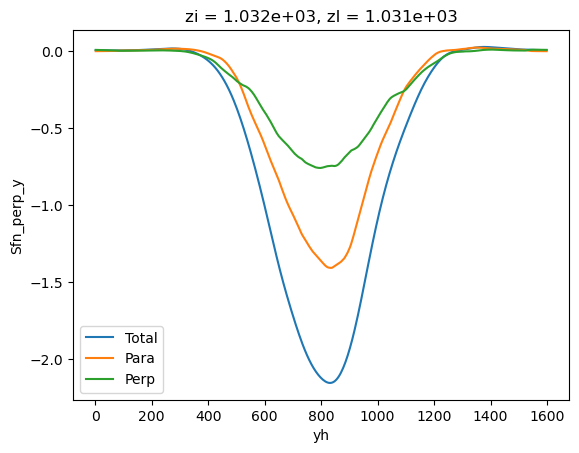

In [20]:
ds.Sfny.isel(Time=slice(0,100)).mean(['xh','Time']).plot(label='Total')
ds.Sfn_para_y.isel(Time=slice(0,100)).mean(['xh','Time']).plot(label='Para')
ds.Sfn_perp_y.isel(Time=slice(0,100)).mean(['xh','Time']).plot(label='Perp')
plt.legend()

### Flux div

In [21]:
def flux_div(ds, xgrid, xflux='Sfnx', yflux='Sfny'):
    Fx = ds[xflux]
    Fy = ds[yflux]

    dx = ds.xh.diff('xh')[0].values*1e3

    dFdx = xgrid.interp(xgrid.diff(Fx,'X')/dx, 'X')
    dFdy = xgrid.interp(xgrid.diff(Fy,'Y')/dx, 'Y')

    divF = dFdx + dFdy
    
    return divF, dFdx, dFdy

In [26]:
divF, _, _ = flux_div(ds, xgrid)
divF_perp, _, _ = flux_div(ds, xgrid, xflux='Sfn_perp_x', yflux='Sfn_perp_y')
divF_para, _, _ = flux_div(ds, xgrid, xflux='Sfn_para_x', yflux='Sfn_para_y')

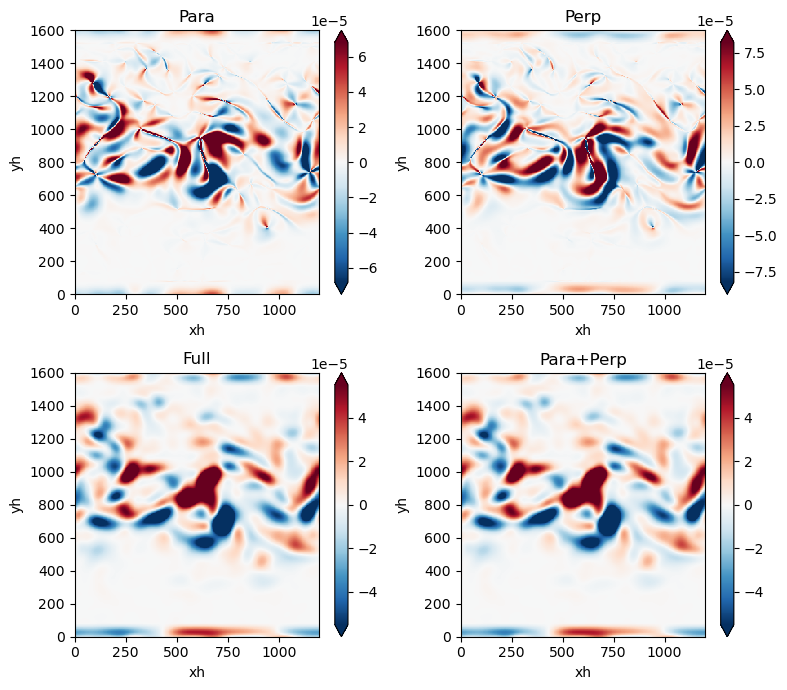

In [27]:
plt.figure(figsize=(8, 7))

plt.subplot(221)
divF_para.isel(Time=-1).plot(robust=True)
plt.title('Para')

plt.subplot(222)
divF_perp.isel(Time=-1).plot(robust=True)
plt.title('Perp')

plt.subplot(223)
divF.isel(Time=-1).plot(robust=True)
plt.title('Full')

plt.subplot(224)
(divF_para + divF_perp).isel(Time=-1).plot(robust=True)
plt.title('Para+Perp')

plt.tight_layout()

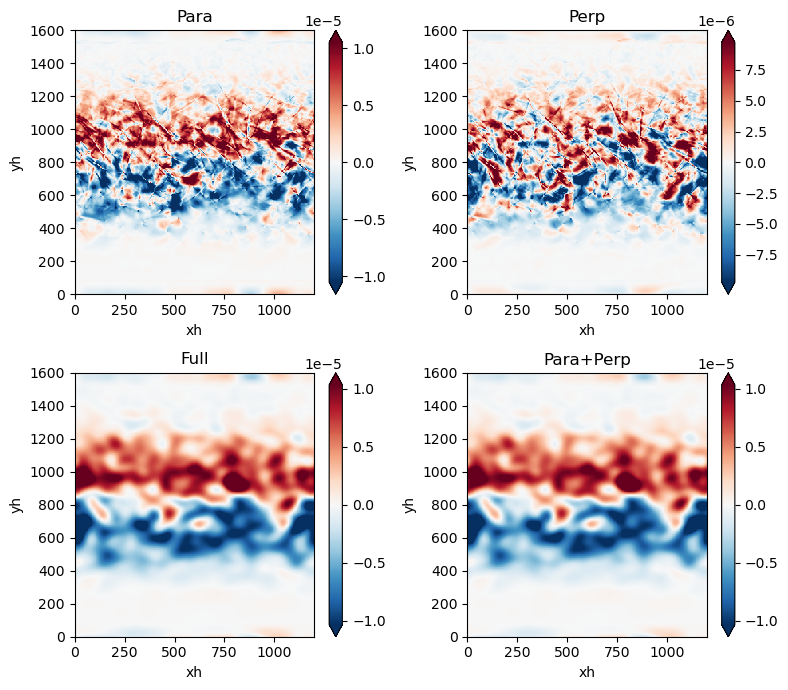

In [28]:
plt.figure(figsize=(8, 7))

plt.subplot(221)
divF_para.isel(Time=slice(0,100)).mean('Time').plot(robust=True)
plt.title('Para')

plt.subplot(222)
divF_perp.isel(Time=slice(0,100)).mean('Time').plot(robust=True)
plt.title('Perp')

plt.subplot(223)
divF.isel(Time=slice(0,100)).mean('Time').plot(robust=True)
plt.title('Full')

plt.subplot(224)
(divF_para + divF_perp).isel(Time=slice(0,100)).mean('Time').plot(robust=True)
plt.title('Para+Perp')

plt.tight_layout()

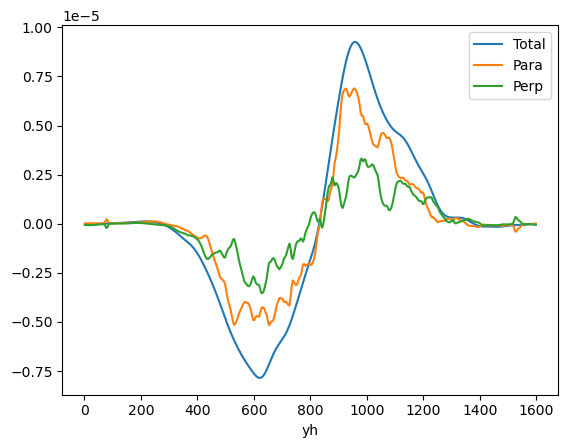

In [29]:
divF.mean(['xh','Time']).plot(label='Total')
divF_para.mean(['xh','Time']).plot(label='Para')
divF_perp.mean(['xh','Time']).plot(label='Perp')
plt.legend()